# XGBoost Predictive Model for TikTok's Claim Classification: EDA, Hypothesis Testing, Logistic Regression, Tree-Based Models

### 5th Jupyter Notebook -- Building Machine Learning Model

## *Classification of Claim Videos*

**The purpose:** Increase response time and system efficiency by automating the initial stages of the claims process.

**The goal:** Predict whether a TikTok video presents a "claim" or presents an "opinion".

**Part 1:** Dataset Examination, Ethical considerations

**Part 2:** Feature engineering

**Part 3:** Modeling

### Business Need and Modeling Objective

TikTok users can report videos which might be violating the platform's terms of service. Because there are millions of TikTok videos created and viewed every day, many videos get reported — too many to be individually reviewed by a human moderator.

Previous work indicated that when authors do violate the terms of service, they're much more likely to posting a claim than an opinion. Therefore, determining which videos make claims and which videos are opinions is useful.

TikTok wants to a machine learning model to help identify claims and opinions. 
Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. 
*For example,* perhaps videos that are classified as claims would then be ranked by how many times they were reported, then the top X% would be reviewed by a human each day.

***A machine learning model would greatly assist in the effort to present human moderators with videos that are most likely to be in violation of TikTok's terms of service.***

### Model Design and Target Variable

Column 'claim_status' is binary value that indicates whether a video is a claim or an opinion. It will be the target variable. 

***This is a classification task since the model is predicting a binary class.***

### Selecting an Evaluation Metric

To determine which evaluation metric might be best, how the model might can be wrong should be considered. 

There are two possibilities for bad predictions:
- False positives (FP): When the model predicts a video is a claim when in fact it is an opinion
- False negatives (FN): When the model predicts a video is an opinion when in fact it is a claim

In the given scenario, **it's better for the model to predict FPs when it makes a mistake, and worse for it to predict FNs**. It's significant to identify videos that violate the terms of service, even if that means some opinion videos are misclassified as claims. 
- The worst case for an opinion misclassified as a claim is that the video goes to human review. 
- The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed and it violates the terms of service. 

***Because it's more important to minimize FNs, the model evaluation metric will be recall.***

### Modeling Workflow & Model Selection Process 

Previous analysis of the dataset has showed that there are ~20,000 videos in the sample. This is sufficient to conduct a rigorous model validation workflow, broken into the following steps:

1) Split the data into train/validation/test sets (60/20/20)

2) Fit models and tune hyperparameters on the training set

3) Perform final model selection on the validation set

4) Assess the champion model's performance on the test set

### Importing and data loading

In [1]:
# Packages for data manipulation
import numpy as np
import pandas as pd

# Packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
import sklearn.metrics as metrics

import pickle

In [2]:
data = pd.read_csv("tiktok-dataset.csv")

### Examining data, summary info, and descriptive stats

In [3]:
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [4]:
data.shape

(19382, 12)

In [5]:
data.dtypes

#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [7]:
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [8]:
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [9]:
data_subset = data.dropna(axis = 0).reset_index(drop = True)

In [10]:
data_subset.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [11]:
data_subset.duplicated().sum()

0

**Note!!!** ***Tree-based models are robust to outliers; thus, no need to handle outliers.***

In [12]:
# Checking class balance
data_subset['claim_status'].value_counts(normalize = True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

### Feature engineering

In [13]:
# Extracting each `video_transcription_text` length info into new column
data_subset['video_text_length'] = data_subset['video_transcription_text'].str.len()
data_subset.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,video_text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [14]:
# Calculating avg. video_text_length of each class
data_subset[['claim_status', 'video_text_length']].groupby(by = ['claim_status']).mean()

,video_text_length
claim_status,
claim,95.376978
opinion,82.722562


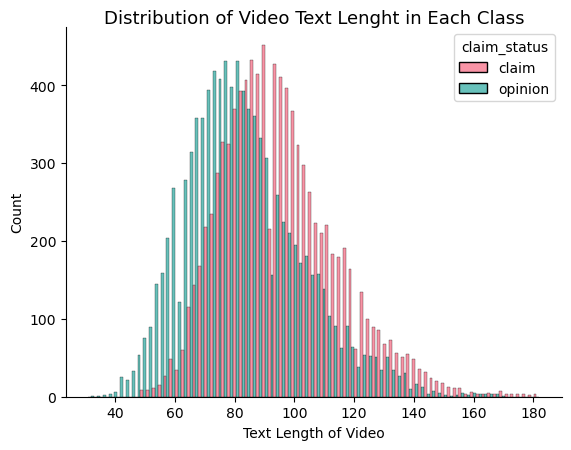

In [15]:
# Visualizing the distribution of `video_text_length` for each class
sns.histplot(data = data_subset, 
             x = 'video_text_length', hue = 'claim_status', 
             stat = 'count', element = 'bars', multiple = 'dodge',
             palette = 'husl', legend = True)
plt.xlabel('Text Length of Video')
plt.ylabel('Count')
plt.title('Distribution of Video Text Lenght in Each Class', pad = 2, fontsize = 13)

sns.despine()
plt.savefig("Distribution-of-Video-Text-Length-Based-on-Claim.png", dpi = 300, bbox_inches = 'tight')
plt.show()

**Remarks:**
1) Length of video text for both claims and opinions are normally distributed with slight right skew. 
2) Claim videos tend to have more characters as shown by previous output.

### Feature selection and transformation

In [16]:
# Dropping unnecessary features
X = data_subset.copy()
X = X.drop(['#', 'video_id', 'video_transcription_text'], axis = 1)

# Encoding target variable
X['claim_status'] = X['claim_status'].map({'opinion': 0, 'claim': 1}) 

# Dummy encoding remaining categorical values
X = pd.get_dummies(X, columns = ['verified_status','author_ban_status'], drop_first = True)

X.head()

,claim_status,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,video_text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,1,31,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,1,25,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,1,19,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


### Splitting the data

In [17]:
y = X['claim_status']
X = X.drop('claim_status', axis = 1)
X.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,video_text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,343296.0,19425.0,241.0,1.0,0.0,97,False,False,True
1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,False,False,False
2,31,902185.0,97690.0,2858.0,833.0,329.0,137,False,False,False
3,25,437506.0,239954.0,34812.0,1234.0,584.0,131,False,False,False
4,19,56167.0,34987.0,4110.0,547.0,152.0,128,False,False,False


In [18]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

In [19]:
# Splitting training data into training and validation sets -- final ratio will be 60/20/20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 0)

In [20]:
# Confirming shape of each training, validation, and testing set are in alignment
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 10), (3817, 10), (3817, 10), (11450,), (3817,), (3817,))

### Building random forest model

In [21]:
# Utilizing cross-validation to tune the hyperparameters and select the model that performs best on recall

# Instantiating the random forest classifier
rf = RandomForestClassifier(random_state = 0)

# Creating dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 8, None], 
             'n_estimators': [75, 100, 150], 
             'min_samples_leaf':[2, 3], 
             'min_samples_split':[4, 5], 
             'max_features':[0.3, 0.5], 
             'max_samples':[0.8]}

# Defining dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiating the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring = scoring, cv = 5, refit = 'recall')

In [22]:
%time
rf_cv.fit(X_train, y_train)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10 µs


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 8, None], 'max_features': [0.3, 0.5],
                         'max_samples': [0.8], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [4, 5],
                         'n_estimators': [75, 100, 150]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [23]:
# Defining path to the folder where the model will be saved
path = '/Users/sevilaymuniregirgin/Desktop/Google-DA-Course/project-no.5-Tiktok-ML/JupyterFiles'

In [24]:
# Function to pickle the model

def write_pickle(path, model_object, save_as:str):
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [25]:
# Function to read pickled model

def read_pickle(path, saved_model_name:str):
    with open(path + saved_model_name + '.pickle', 'rb') as to_read: 
        model = pickle.load(to_read)
    return model

In [26]:
# Writing the pickle
write_pickle(path, rf_cv, 'hr_rf_cv')

In [27]:
# Reading saved pickle
rf = read_pickle(path, 'hr_rf_cv')

In [28]:
# Getting best recall score
rf_cv.best_score_

0.9911419116227436

In [29]:
# Examining best parameters
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 0.5,
 'max_samples': 0.8,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 75}

In [30]:
# Getting all results from the CV and putting them in a df
# Isolating the row of the df with the max(mean precision score)

def make_results(model_name, model_object):
    cv_results = pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_precision'].idxmax(), :]
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    
    table = pd.DataFrame({'Model': [model_name], 'F1': [f1],
                         'Precision': [precision],
                         'Recall': [recall],
                         'Accuracy': [accuracy]})
    return table

In [31]:
rf_cv_table = make_results('Random Forest CV', rf_cv) 
rf_cv_table

,Model,F1,Precision,Recall,Accuracy
0,Random Forest CV,0.995462,1.0,0.990968,0.995459


**Remarks:** 

This model performs exceptionally well, with an **average recall score of 0.991** across the five cross-validation folds. 
Also mean precision score is 0.999. 

All in all, **the model is making almost perfect classifications.**

### Building XGBoost model

In [32]:
# Could not complete GridSearchCV due to computational problem; but, required code is added as comment
# Creating new dictionary of hyperparameters to tune
# cv_params_2 = {'max_depth': [9,12], 'min_child_weight': [2, 5], 
#                'learning_rate': [0.01, 0.1], 'n_estimators': [200, 300]}

# Instantiating the GridSearchCV object
# xgb_cv = GridSearchCV(xgb, cv_params_2, scoring = scoring, cv = 5, refit = 'recall')



# Instantiating the XGBoost classifier with parameters (intellectual guess)
xgb = XGBClassifier(objective = 'binary:logistic', learning_rate = 0.1, max_depth = 4,
                    min_child_weight = 5, n_estimators = 300, random_state = 0)

In [33]:
%time
xgb.fit(X_val, y_val)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

###  Evaluating models

#### Evaluation of Random Forest

In [34]:
# Using random forest "best estimator" model to get predictions on validation data
y_preds = rf_cv.best_estimator_.predict(X_val)

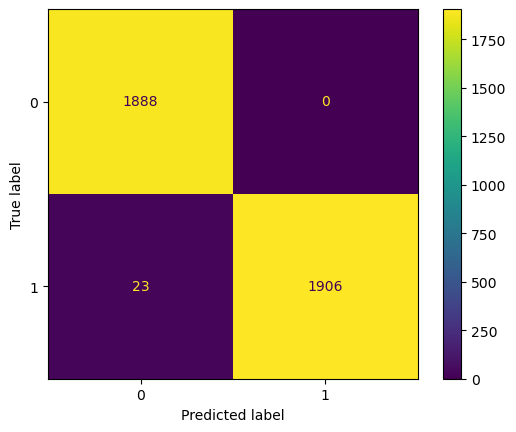

In [35]:
# Creating confusion matrix to visualize results of the RF classification model
rf_val_cm = metrics.confusion_matrix(y_val, y_preds)
rf_val_cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix = rf_val_cm, display_labels = rf_cv.classes_)
rf_val_cm_disp.plot()

plt.savefig("Confusion-Matrix-Random-Forest-ValidationDataset.png", dpi = 300, bbox_inches = 'tight')
plt.show()

In [36]:
# Creating classification report for random forest model
target_labels = ['opinion', 'claim']
print(metrics.classification_report(y_val, y_preds, target_names = target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1888
       claim       1.00      0.99      0.99      1929

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



#### Evaluation of XGBoost

In [37]:
# Getting predictions from XGBoost model on validation set
y_preds_2 = xgb.predict(X_val)

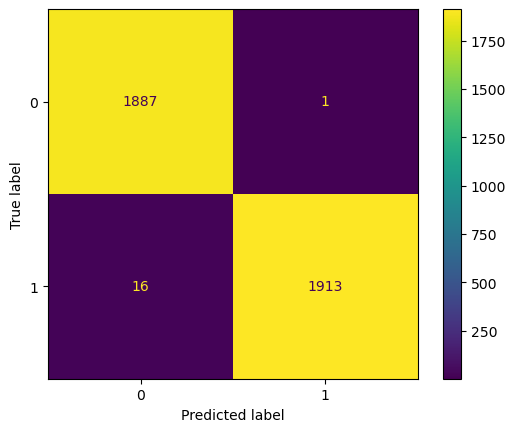

In [38]:
# Generating confusion matrix for XGBoost model
xgb_val_cm = metrics.confusion_matrix(y_val, y_preds_2)
xgb_val_cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix = xgb_val_cm, display_labels = xgb.classes_)
xgb_val_cm_disp.plot()

plt.savefig("Confusion-Matrix-XGBoost-ValidationDataset.png", dpi = 300, bbox_inches = 'tight')
plt.show()

In [39]:
# Making classification report for XGBoost model
print(metrics.classification_report(y_val, y_preds_2, target_names = target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1888
       claim       1.00      0.99      1.00      1929

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



**Remarks:** 
The results of both Random Forest and XGBoost model were nearly perfect. 

In conclusion, XGBoost made less errors (regarding both FP and FN); therefore, **XGBoost is the champion model.**

### Using champion model to predict on test data

In [40]:
y_preds_final = xgb.predict(X_test)

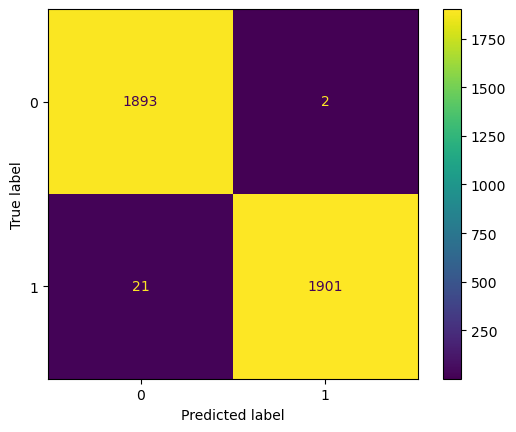

In [41]:
# Computing confusion matrix

xgb_cm = metrics.confusion_matrix(y_test, y_preds_final)
xgb_cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix = xgb_cm, display_labels = xgb.classes_)
xgb_cm_disp.plot()

plt.savefig("Confusion-Matrix-XGBoost-TestData.png", dpi = 300, bbox_inches = 'tight')
plt.show()

#### **Feature importances of champion model**


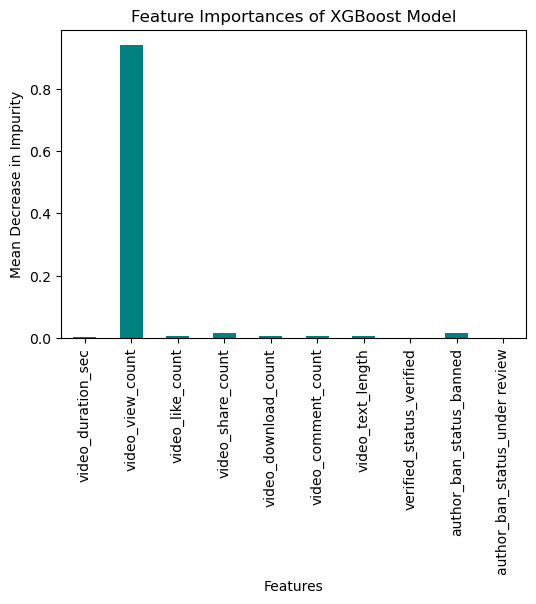

In [42]:
importances = xgb.feature_importances_
xgb_importances = pd.Series(importances, index = X_test.columns)

plt.figure(figsize = (6,4))
xgb_importances.plot.bar(color = 'teal')
plt.title('Feature Importances of XGBoost Model')
plt.xlabel('Features')
plt.ylabel('Mean Decrease in Impurity')

plt.savefig("Feature-Importance-XGBoost.png", dpi = 300, bbox_inches = 'tight')
plt.show()

**Remarks:** 
- The most predictive features 'video_view_count' and 'video_share_count' are related to engagement levels generated by the video. Prior EDA pointed to this conclusion.
- Moreover, the plot indicates that 'author_ban_status_banned' is a decent predictor for the model.

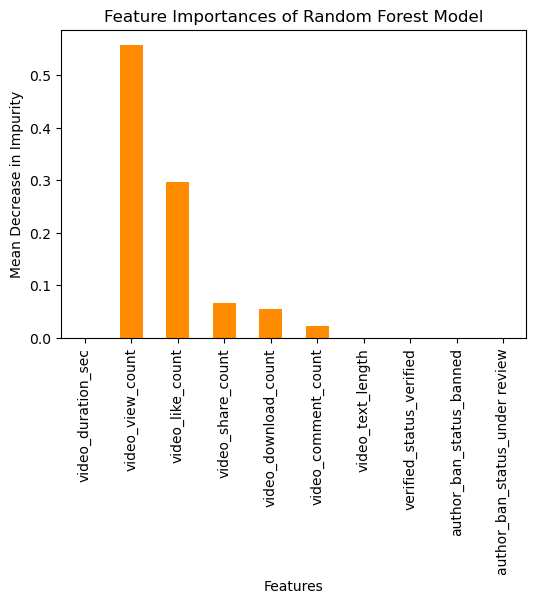

In [43]:
importances_rf = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances_rf, index = X_train.columns)

plt.figure(figsize = (6,4))
rf_importances.plot.bar(color = 'darkorange')
plt.title('Feature Importances of Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Mean Decrease in Impurity')

plt.savefig("Feature-Importance-Random-Forest.png", dpi = 300, bbox_inches = 'tight')
plt.show()

**Remarks:** 
The most predictive features are related to video engagement levels:
- 'video_view_count'
- 'video_like_count'
- 'video_share_count' 
- 'video_comment_count'

Random Forest model yielded more features compare to XGBoost. Since both model performed very similarly on validation dataset, one can ***also choose Random Forest as its champion model.***